<a href="https://colab.research.google.com/github/eldhosejoseph/thesis/blob/main/BCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 26.8 MB/s eta 0:00:00


In [2]:

import mne
import os
import pandas as pd
import numpy as np

In [3]:
!git clone https://github.com/OpenNeuroDatasets/ds004511.git

Cloning into 'ds004511'...
remote: Enumerating objects: 4554, done.
remote: Counting objects: 100% (4554/4554), done.
remote: Compressing objects: 100% (2983/2983), done.
remote: Total 4554 (delta 592), reused 4535 (delta 573), pack-reused 0
Receiving objects: 100% (4554/4554), 2.74 MiB | 13.56 MiB/s, done.
Resolving deltas: 100% (592/592), done.


In [4]:
!pip install PyQt5


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 614.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 kB 544.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 1.4 MB/s eta 0:00:00


In [6]:
import matplotlib
matplotlib.use('agg')

In [7]:
dataset_path = "ds004511"

In [ ]:
url="sub-S200120/ses-01/eeg/sub-S200120_ses-01_task-CC_run-01_channels.tsv"

In [8]:
url="sub-S200120/ses-01/eeg/sub-S200120_ses-01_task-GG_run-01_channels.tsv"

In [40]:
# Assuming eeg_data_path is the path to your EEG data file
eeg_data_path = os.path.join(dataset_path, url)

try:
    # Attempt to read the TSV file with tab-separated values, skipping lines with bad data
    eeg_data = pd.read_csv(eeg_data_path, sep='\t', error_bad_lines=False)

    # Remove non-numeric columns
    eeg_data = eeg_data.select_dtypes(include=[np.number])

     # Replace infs and NaNs with appropriate values
    eeg_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    eeg_data.fillna(0, inplace=True)  # Replace NaNs with 0
    # Extract channel names and create MNE info object
    ch_names = eeg_data.columns.tolist()
    sfreq = 3000  # Example sampling frequency (adjust according to your data)
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')

    # Create MNE Raw object
    raw = mne.io.RawArray(eeg_data.values.T, info)
    if len(raw.times) == 0:
        raise ValueError("Empty raw object. No data found.")
    raw.filter(l_freq=1.0, h_freq=None)
    print(raw.info)
    raw.plot()

except ValueError:
    # Handle the case where the file contains non-numeric data
    print("Error: TSV file contains non-numeric data.")

Creating RawArray with float64 data, n_channels=4, n_times=139
    Range : 0 ... 138 =      0.000 ...     0.046 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 9901 samples (3.300 s)



<ipython-input-40-e8e90a34613f>:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  eeg_data = pd.read_csv(eeg_data_path, sep='\t', error_bad_lines=False)
<ipython-input-40-e8e90a34613f>:23: RuntimeWarning: filter_length (9901) is longer than the signal (139), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=1.0, h_freq=None)


<Info | 7 non-empty values
 bads: []
 ch_names: low_cutoff, high_cutoff, sampling_frequency, status_description
 chs: 4 EEG
 custom_ref_applied: False
 highpass: 1.0 Hz
 lowpass: 1500.0 Hz
 meas_date: unspecified
 nchan: 4
 projs: []
 sfreq: 3000.0 Hz
>


In [41]:
# 1. Check for bad channels using variance
# Compute variance along each channel
channel_variance = raw._data.var(axis=1)

# Set a threshold for variance to identify potential bad channels
variance_threshold = 1e-6  # Adjust as per your data
bad_channels = [ch for ch, var in zip(raw.ch_names, channel_variance) if var < variance_threshold]

print("Bad channels:", bad_channels)

Bad channels: ['low_cutoff', 'status_description']


In [ ]:
import traceback
try:
    # Perform ICA fitting
    #n_components = min(20, len(raw.ch_names))
    n_components=4
    ica = mne.preprocessing.ICA(n_components=n_components, random_state=97)
    ica.fit(raw)

    # Plot components
    ica.plot_components(raw)

except IndexError as e:
    # Handle the IndexError and print the full traceback
    print("IndexError occurred during ICA fitting:")
    traceback.print_exc()
except Exception as e:
    # Handle other unexpected errors and print the full traceback
    print("Unexpected error occurred during ICA fitting:")
    traceback.print_exc()

Effective window size : 0.046 (s)


<ipython-input-43-7579b94c97ab>:1: UserWarning: Zero value in spectrum for channels low_cutoff, status_description
  raw.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
<ipython-input-43-7579b94c97ab>:1: UserWarning: Infinite value in PSD for channels low_cutoff, status_description.
These channels might be dead.
  raw.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
<ipython-input-43-7579b94c97ab>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)


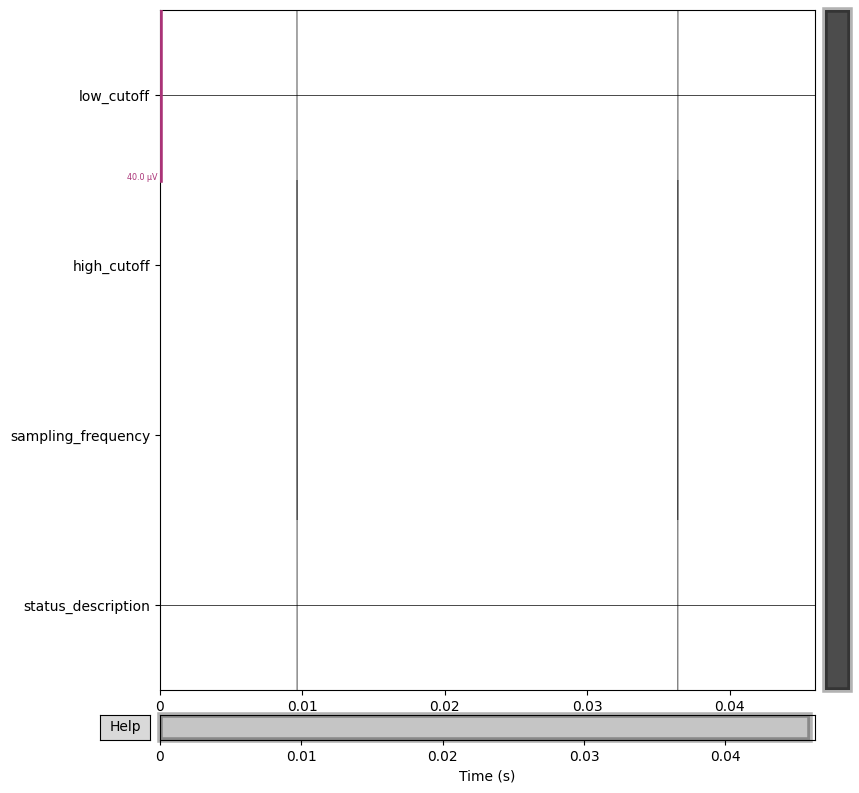

In [43]:
raw.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
raw.plot(duration=5, n_channels=9)

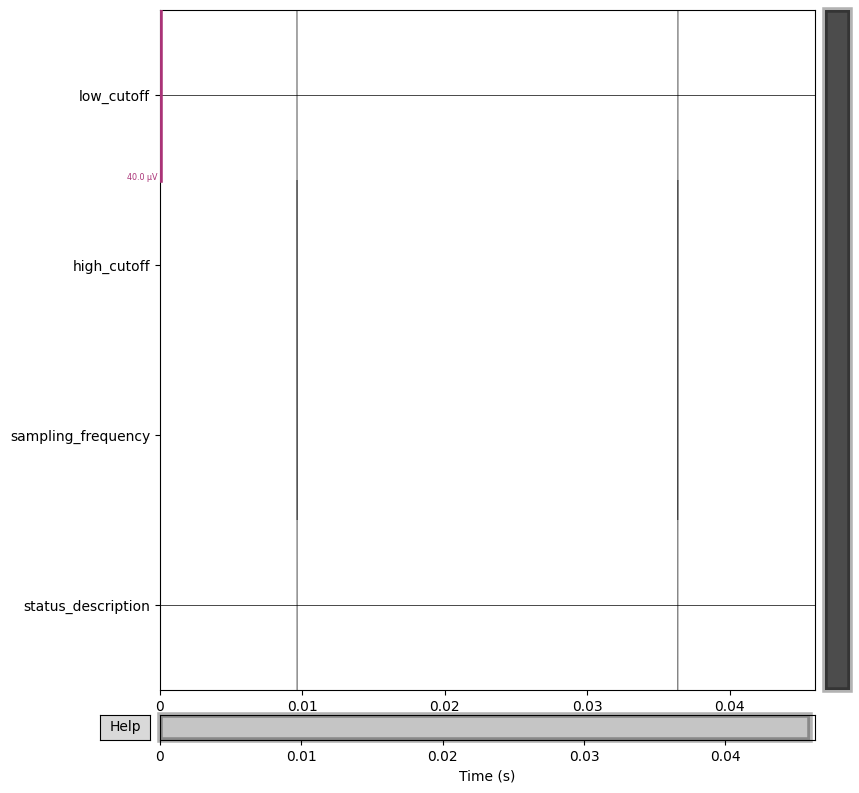

In [44]:
raw.plot()

In [31]:
raw.close()